In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import os

In [0]:

from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir /root/.kaggle
!echo '{"username":"aneeshmuppidi19","key":"79406aaa5498c938d4f8f50e3b0f3fca"}' > /root/.kaggle/kaggle.json


In [0]:
import os
os.makedirs("/content/competitions/CarNet")



In [0]:
os.chdir('/content/competitions/CarNet')
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder


100% 1.82G/1.83G [00:35<00:00, 53.7MB/s]
100% 1.83G/1.83G [00:35<00:00, 54.9MB/s]


In [0]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/04688.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/04772.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/05544.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/05728.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/05860.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06146.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06157.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06332.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06441.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06447.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06590.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06650.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06742.jpg  


In [0]:
data_dir = '/content/competitions/CarNet/car_data/car_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
# Training transform includes random rotation and flip to build a more robust model
train_transforms = transforms.Compose([transforms.Resize((244,244)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# The validation set will use the same transform as the test set
test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_transforms = transforms.Compose([transforms.Resize((244,244)),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/test', transform=validation_transforms)

# Using the image datasets and the trainforms, define the dataloaders
# The trainloader will have shuffle=True so that the order of the images do not affect the model
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)

In [0]:
model = models.resnet34(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [0]:
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    
    # change model to work with cuda
    model.to('cuda')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):
    
        # Change images and labels to work with cuda
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)
        
        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [0]:
epochs = 10
steps = 0
print_every = 40

# change to gpu mode
model.to('cuda')
model.train()
for e in range(epochs):

    running_loss = 0
    
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # zeroing parameter gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()
            
            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Valid Loss: {round(valid_loss/len(validloader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")
            
            
            # Turning training back on
            model.train()
            lrscheduler.step(accuracy * 100)

No. epochs: 1,             Training Loss: 5.221             Valid Loss: 4.737             Valid Accuracy: 0.062
No. epochs: 2,             Training Loss: 1.507             Valid Loss: 3.601             Valid Accuracy: 0.204
No. epochs: 2,             Training Loss: 4.651             Valid Loss: 2.707             Valid Accuracy: 0.329
No. epochs: 3,             Training Loss: 1.729             Valid Loss: 2.134             Valid Accuracy: 0.472
No. epochs: 4,             Training Loss: 0.278             Valid Loss: 1.76             Valid Accuracy: 0.531
No. epochs: 4,             Training Loss: 1.532             Valid Loss: 1.346             Valid Accuracy: 0.645
No. epochs: 5,             Training Loss: 0.506             Valid Loss: 1.314             Valid Accuracy: 0.661
No. epochs: 5,             Training Loss: 1.31             Valid Loss: 1.082             Valid Accuracy: 0.704
No. epochs: 6,             Training Loss: 0.54             Valid Loss: 0.816             Valid Accuracy: 0

In [0]:
correct = 0
total = 0
model.to('cuda')


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

Test accuracy of model: 76.632%


In [0]:
checkpoint = {'state_dict': model.state_dict(),
              'model': model.fc,
              'class_to_idx': train_data.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs}

torch.save(checkpoint, '/content/drive/My Drive/Colab Notebooks/carsdata/my_checkpoint1.pth')

In [0]:
def load_checkpoint(filepath):

    checkpoint = torch.load(filepath)
    
    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [0]:
model2 =  models.resnet34(pretrained=True)
model2 = load_checkpoint('/content/drive/My Drive/Colab Notebooks/carsdata/my_checkpoint1.pth')


In [0]:
print(model2)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
model2 = torch.nn.DataParallel(model)


In [0]:
def process_image(image):
    
    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg').convert('RGB')
 


    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]) 
    
    # Transforming image for use with network
    pil_tfd = transform(pil_im)
    
    # Converting to Numpy array 
    array_im_tfd = np.array(pil_tfd)
    
    return array_im_tfd

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

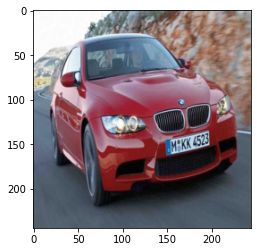

In [0]:
imshow(process_image(data_dir + '/test/BMW M3 Coupe 2012/00103'))


In [0]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file   
    
    # Loading model - using .cpu() for working with CPUs
    loaded_model = load_checkpoint(model).cpu()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)
        
    #conf, predicted = torch.max(output.data, 1)   
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]
    
    # Converting probabilities and outputs to lists
    conf = np.array(probs_top)[0]
    predicted = np.array(predicted_top)[0]
        
    #return probs_top_list, index_top_list
    return conf, predicted

In [0]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(data_dir+"/train")


In [0]:
model_path = '/content/drive/My Drive/Colab Notebooks/carsdata/my_checkpoint1.pth'
image_path = '/content/drive/My Drive/Colab Notebooks/carsdata/bmwsuv'
conf1, predicted1 = predict(image_path, model_path, topk=5)
print(conf1)
print(classes[predicted1[0]])

[3.6913142 3.6330366 3.5631337 3.3130388 3.0513954]
BMW X3 SUV 2012
